In [1]:
import os
import numpy as np 
from numpy import identity, sum
from numpy import transpose as tr
from numpy import diagflat as to_diag
from scipy.linalg import expm, inv, null_space
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def ErlangB(n,x):
    sum = num = den = 1
    for i in range(1, n+1): 
        num *= x
        den *= i
        sum += num/den
    return  num / den / sum
def ErlangC(n,x):
      return n*ErlangB(n,x)/(n-x*(1-ErlangB(n,x)))
def VQT_MMc(c=2, Œª=1, Œº2=0.55):
    rho = Œª/(c*Œº2)
    pWait = ErlangC(c,Œª/Œº2)
    VQTcdf = lambda x : 1 - pWait * np.exp(-c*Œº2*(1-rho)*x)
    VQTdf = lambda x : pWait * np.exp(-c*Œº2*(1-rho)*x) * c * Œº2 *(1-rho)
    VQTmean = pWait/(c * Œº2 * (1-rho))
    return VQTcdf, VQTdf, VQTmean

In [3]:
def VQT(c=2, Œª=1, Œº1=0.45, Œº2=0.55, k=0.1):

    if  Œº1==Œº2:
        return VQT_MMc(c,Œª,Œº2)

    # Definitions
    Œº = lambda i, j : i * Œº1 + j * Œº2
    Œî0 = np.diag([Œº(i,c-1-i) for i in range(c)])
    Œî1 = np.diag([Œº(i+1,c-1-i) for i in range(c)])
    Œî2 = np.diag([Œº(i,c-i) for i in range(c)])

    Œºvec = lambda n : [Œº(i,n-i) for i in range(n+1)]
    hŒî = lambda n : np.diag(Œºvec(n))
    hB = lambda n : np.array([[(i==j)*(n+1-i)*Œº2+(i==j+1)*i*Œº1 for j in range(n+1)] for i in range(n+2)])
    hI = lambda n : np.array([[(i+1==j)*1 for j in range(n+1)] for i in range(n)])

    Q1 = lambda x : expm(-x*Œî1)
    Q2 = lambda x : expm(-x*Œî2)
    B1 = np.array([[(i==j)*(i+1)*Œº1+(i+1==j)*(c-1-i)*Œº2 for j in range(c)] for i in range(c)])
    B2 = np.array([[(i==j)*(c-i)*Œº2+(i-1==j)*i*Œº1 for j in range(c)] for i in range(c)])

    tŒî1 = np.linalg.inv(B1) @ Œî1 @ B1
    tŒî2 = np.linalg.inv(B2) @ Œî2 @ B2
    tQ1 = lambda x : inv(B1) @ Q1(x) @ B1
    tQ2 = lambda x : inv(B2) @ Q2(x) @ B2

    # Solving homogeneous equations
    D1 = lambda x : pow(x,2) * identity(c) - x * (Œª * identity(c) - tŒî1) + Œª * (B1 - tŒî1)
    D2 = lambda x : pow(x,2) * identity(c) - x * (Œª * identity(c) - tŒî2) + Œª * (B2 - tŒî2)
    
    # Chop function
    def chop(expr, delta=10**-14):
        return np.ma.masked_inside(expr, -delta, delta).filled(0)
    # Eigenvector function
    eigenvector = lambda x : tr(null_space(tr(chop(x))))

    Œ∏1P = [(Œª-Œº(i+1,c-1-i)+np.sqrt(pow(Œª-Œº(i+1,c-1-i),2)+4*Œª*Œº(0,c-1-i)))/2 for i in range(c)]
    Œ∏1N = [(Œª-Œº(i+1,c-1-i)-np.sqrt(pow(Œª-Œº(i+1,c-1-i),2)+4*Œª*Œº(0,c-1-i)))/2 for i in range(c)]
    Œ∏2P = [(Œª-Œº(i,c-i)+np.sqrt(pow(Œª-Œº(i,c-i),2)+4*Œª*Œº(i,0)))/2 for i in range(c)]
    Œ∏2N = [(Œª-Œº(i,c-i)-np.sqrt(pow(Œª-Œº(i,c-i),2)+4*Œª*Œº(i,0)))/2 for i in range(c)]

    …∏1P = np.concatenate([eigenvector(D1(Œ∏1P[i])) for i in range(c)])
    …∏1N = np.concatenate([eigenvector(D1(Œ∏1N[i])) for i in range(c)])
    …∏2P = np.concatenate([eigenvector(D2(Œ∏2P[i])) for i in range(c)])
    …∏2N = np.concatenate([eigenvector(D2(Œ∏2N[i])) for i in range(c)])

    U1P = inv(…∏1P) @ to_diag(Œ∏1P) @ …∏1P
    U1N = inv(…∏1N) @ to_diag(Œ∏1N) @ …∏1N
    U2P = inv(…∏2P) @ to_diag(Œ∏2P) @ …∏2P
    U2N = inv(…∏2N) @ to_diag(Œ∏2N) @ …∏2N
    
    # Useful matrices
    iU1PU1N = inv(U1P - U1N)
    itŒî1 = inv(tŒî1)
    itŒî2 = inv(tŒî2)
    
    ikexp = np.vectorize(lambda x : k if x==0 else (np.exp(k*x)-1)/x)
    IkU1P = inv(…∏1P) @ to_diag(ikexp(Œ∏1P)) @ …∏1P
    IkU1N = inv(…∏1N) @ to_diag(ikexp(Œ∏1N)) @ …∏1N

    # Solving homogeneous equations
    vŒ∑1 = eigenvector(D1(0))
    MŒ∑1 = Œª * (B1 - tŒî1) - to_diag(vŒ∑1)
    M0 = inv(MŒ∑1)
    vŒ∑2 = eigenvector(D2(0))
    MŒ∑2 = Œª * (B2 - tŒî2) - to_diag(vŒ∑2)
    M1 = inv(MŒ∑2)
    M2 = inv((Œî1[-1,-1] + Œª) * (Œî1[-1,-1] * identity(c) - tŒî2) + Œª * B2)

    H1 = iU1PU1N @ (expm(k * U1P) - expm(k * U1N))
    H2 = M0 @ (identity(c) - expm(k* U1N) + U1N @ H1)
    H3 = H1 + tŒî1 @ H2
    H4 = - Œª * B1 @ H2

    H5 = iU1PU1N @ (U1P @ expm(k * U1P) - U1N @ expm(k * U1N))
    H6 = M0 @ (U1N @ expm(k * U1N) - U1N @ H5)
    H7 = H5 - tŒî1 @ H6
    H8 = Œª * B1 @ H6

    H9 = (tŒî1 - tŒî2) @ M2 @ U2N + tŒî1 @ (tŒî1 - tŒî2) @ M2 
    H10 = U2N - Œª * (identity(c) - B2 @ itŒî2) @ H9
    H11 = M1 @ U2N + itŒî2 @ H9
    H12 = H10 + Œª * (B1 @ itŒî1 @ tŒî2 - B2) @ H11
    H13 = tŒî2 @ H11
    H14 = Œª * B1 @ itŒî1 @ tŒî2 @ H11

    H15 = inv(H7 - H7 @ H9 - H3 @ H12 + H13)
    H16 = (H14 + H4 @ H12 - H8 + H8 @ H9) @ H15

    H17 = tŒî2 @ M1 - Œª * H3 @ (B1 @ itŒî1 @ tŒî2 - B2) @ M1
    H18 = Œª * B1 @ itŒî1 @ tŒî2 @ M1 + Œª * H4 @ (B1 @ itŒî1 @ tŒî2 - B2) @ M1
    H19 = identity(c) - U2N @ H15 @ H17
    H20 = H16 @ H17 - H18

    # Solving the final system of equations
    def hC(n):
        if n==0:
            return hB(0) / Œª
        if n<c-1:
            return hB(n) @ inv(Œª * (identity(n+1) - hC(n-1) @ hI(n))+ hŒî(n) )
        if n==c-1:
            return - U2N @ H15 @ inv(Œª * (identity(c) - hC(c-2) @ hI(c-1)) + hŒî(c-1)  - H16)
        return -1

    def hH(n):
        if n==c-1:
            return hC(c-1)
        if n<c-1:
            return hH(n+1) @ hC(n)
        return -1

    bcsol = 1/(sum(vŒ∑2 @ (H19 + hH(c-1) @ H20)) + sum([sum(vŒ∑2 @ hH(n)) for n in range(c)]))
    Œ¥sol = lambda n : bcsol * vŒ∑2 @ hH(n)

    
    # Constructing the VQT stationary distribution function
    vf0sol = Œ¥sol(c-1) @ H16 - bcsol * vŒ∑2 @ U2N @ H15
    vfksol = vf0sol @ H7 + Œ¥sol(c-1) @ H8
    vFksol = vf0sol @ H3 + Œ¥sol(c-1) @ H4

    ùõº0sol = vf0sol @ tŒî1 - Œª * Œ¥sol(c-1) @ B1
    ùõº1sol = ùõº0sol @ itŒî1 @ tŒî2 - Œª * vFksol @ (B1 @ itŒî1 @ tŒî2 - B2)
    ùõº2sol = ùõº1sol @ itŒî2 - vfksol +  Œª * vFksol @ (identity(c) - B2 @ itŒî2)
    
    F2solInf = bcsol * vŒ∑2 @ H19 + Œ¥sol(c-1) @ H20
    VQTpos = 1 - sum(F2solInf)

    # compute the VQT stationary cumulative distribution function
    F1sol = lambda x : (vf0sol + ùõº0sol @ M0 @ U1N) @ iU1PU1N @ (expm(x*U1P) - expm(x*U1N)) + ùõº0sol @ M0 @ (identity(c) - expm(x*U1N))
    F2sol = lambda x : vFksol @ expm((x-k)*U2N) + (bcsol * vŒ∑2 + ùõº1sol @ M1) @ (identity(c) - expm((x-k)*U2N)) - ùõº2sol @ ((tŒî1-tŒî2) @ M2 @ expm((x-k)*U2N) - tQ1(x-k) @ (tŒî1-tŒî2) @ M2)
    Fsol = lambda x :  F1sol(x) if (x<k) else F2sol(x)
    VQTcdf = lambda x :  VQTpos + sum(Fsol(x))

    # compute the VQT stationary density function
    f1sol = lambda x : (vf0sol + ùõº0sol @ M0 @ U1N) @ iU1PU1N @ (U1P @ expm(x*U1P) - U1N @ expm(x*U1N)) - ùõº0sol @ M0 @ U1N @ expm(x*U1N)
    f2sol = lambda x : (vFksol - bcsol * vŒ∑2 - ùõº1sol @ M1 - ùõº2sol @ (tŒî1-tŒî2) @ M2) @ U2N @ expm((x-k)*U2N) - ùõº2sol @ tŒî1 @ tQ1(x-k) @ (tŒî1-tŒî2) @ M2
    fsol = lambda x :  f1sol(x) if (x<k) else f2sol(x)
    VQTdf = lambda x :  sum(fsol(x))

    # compute the VQT stationary mean
    mean = (vf0sol + ùõº0sol @ M0 @ U1N) @ iU1PU1N @ (k * expm(k*U1P) - IkU1P)
    mean -= ((vf0sol + ùõº0sol @ M0 @ U1N) @ iU1PU1N + ùõº0sol @ M0) @ (k * expm(k*U1N) - IkU1N)
    mean += (vFksol - bcsol * vŒ∑2 - ùõº1sol @ M1 - ùõº2sol @ (tŒî1-tŒî2) @ M2) @ (inv(U2N) - k * identity(c))
    mean -= ùõº2sol @ (itŒî1 + k * identity(c)) @ (tŒî1-tŒî2) @ M2

    return VQTcdf, VQTdf, sum(mean)

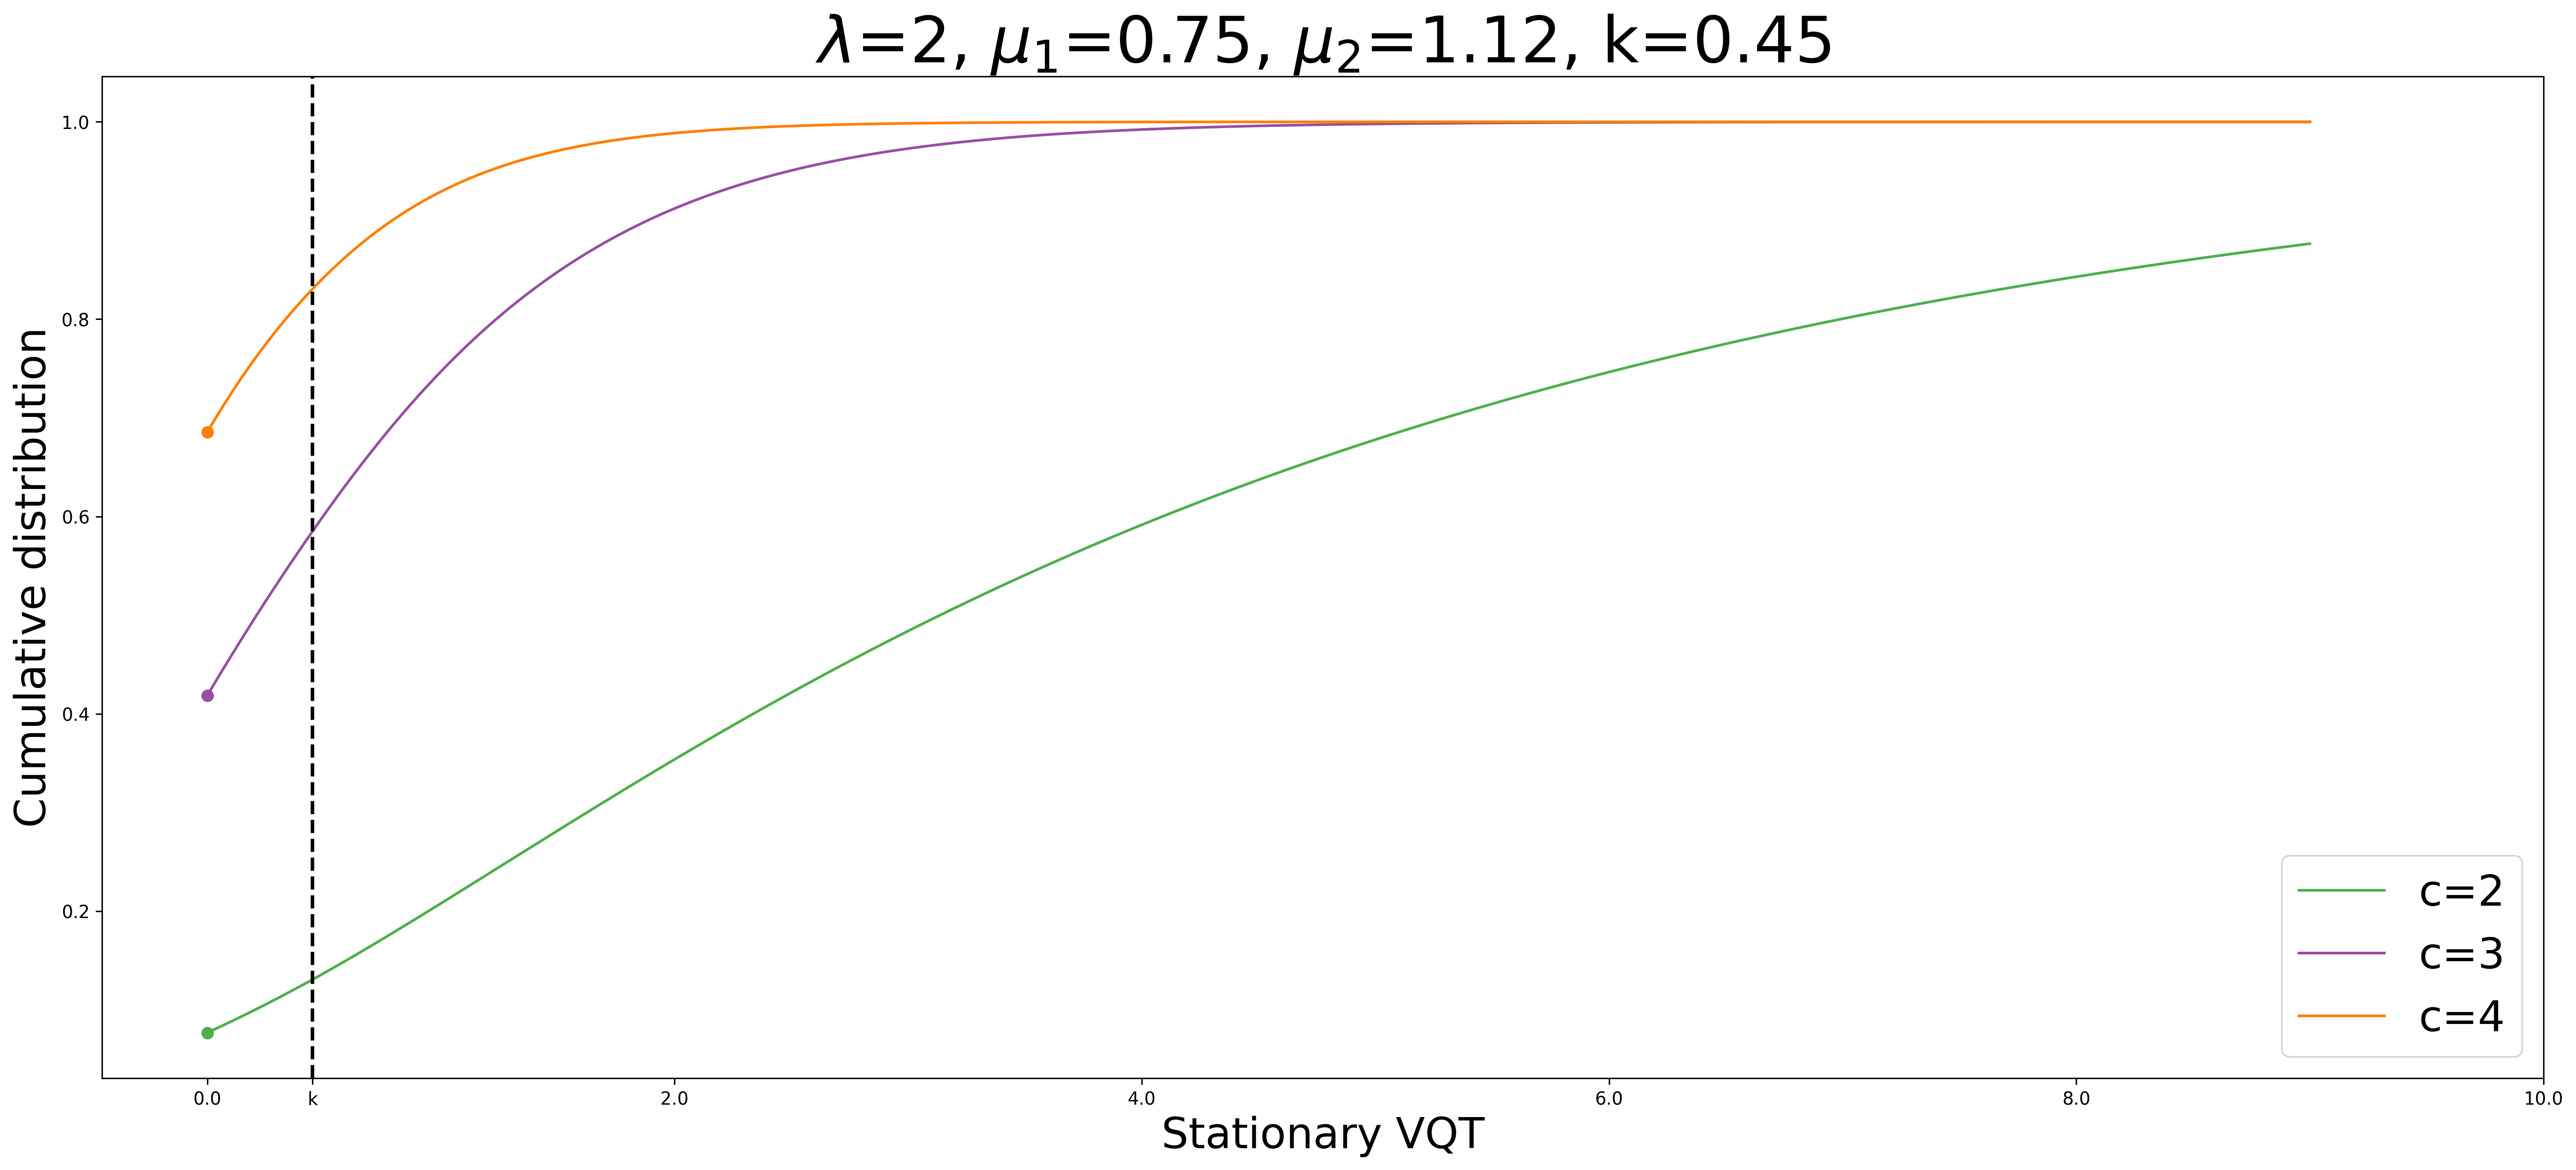

In [4]:
def c_graph(Œª=2, Œº1=0.75, Œº2=1.12, k=0.45, title=True, save=False):
    crange = range(2,5)
    xpoints = np.linspace(start=0, stop=20*k, num=250)
    cmap = plt.get_cmap('Set1')
    plt.figure(figsize=(20, 9), dpi=300, constrained_layout=True)
    for c in crange:
        VQTfun, _, _= VQT(c, Œª, Œº1, Œº2, k)
        plt.plot(xpoints, [VQTfun(x) for x in xpoints],  label=f'c={c}', color=cmap(c)) # plot VQT
        plt.plot(0, VQTfun(0), "o", color=cmap(c)) # mark null VQT probability
    plt.ylabel('Cumulative distribution',fontsize=24)
    plt.xlabel('Stationary VQT',fontsize=24)
    plt.gca().axvline(x=k, linewidth=2, color='k', linestyle="--") # add vertical line at k
    plt.xticks(list(plt.xticks()[0][1:]) + [k], list(plt.xticks()[0][1:]) + ["k"]) # add xtick at k
    plt.legend(loc=4, fontsize=24)
    if title: plt.title(f'$\lambda$={Œª}, $\mu_1$={Œº1}, $\mu_2$={Œº2}, k={k}', fontsize=36)
    if save: # save picture to file
        # basedir = os.path.expanduser("~") + '/Desktop/' # put pictures in Desktop folder
        basedir = os.path.join(os.getcwd(),"img")
        filename = f'vqt_cdf_c_l{Œª}_m{Œº1}_M{Œº2}_k{k}'
        plt.savefig(os.path.join(basedir, filename + ".pdf"), dpi=300)
        plt.savefig(os.path.join(basedir, filename +".jpeg"), dpi=300, format='JPG')
    plt.show()
c_graph(save=False)

In [5]:
def rho_graph(œÅ=0.45, Œº1=0.75, Œº2=1.12, k=0.45, title=True, save=False):
    crange = range(2,5)
    xpoints = np.linspace(start=0, stop=20*k, num=250)
    cmap = plt.get_cmap('Set1')
    plt.figure(figsize=(20, 9), dpi=300, constrained_layout=True)
    for c in crange:
        VQTfun, _, _= VQT(c, œÅ*c*Œº2, Œº1, Œº2, k)
        plt.plot(xpoints, [VQTfun(x) for x in xpoints],  label=f'c={c}', color=cmap(c)) # plot VQT
        plt.plot(0, VQTfun(0), "o", color=cmap(c)) # mark null VQT probability
    plt.ylabel('Cumulative distribution',fontsize=24)
    plt.xlabel('Stationary VQT',fontsize=24)
    plt.gca().axvline(x=k, linewidth=2, color='k', linestyle="--") # add vertical line at k
    plt.xticks(list(plt.xticks()[0][1:]) + [k], list(plt.xticks()[0][1:]) + ["k"]) # add xtick at k
    plt.legend(loc=4, fontsize=24)
    if title: plt.title(f'$\\rho$={œÅ}, $\mu_1$={Œº1}, $\mu_2$={Œº2}, k={k}', fontsize=36)
    if save: # save picture to file
        # basedir = os.path.expanduser("~") + '/Desktop/' # put pictures in Desktop folder
        basedir = os.path.join(os.getcwd(),"img")
        filename = f'vqt_cdf_c_r{œÅ}_m{Œº1}_M{Œº2}_k{k}'
        plt.savefig(os.path.join(basedir, filename + ".pdf"), dpi=300)
        plt.savefig(os.path.join(basedir, filename +".jpeg"), dpi=300, format='JPG')
    plt.show()

In [6]:
interact(c_graph, Œª=(0.1,1.9,0.1), Œº1=(0.15,1.05,0.1), Œº2=(0.8,2,0.1), k=(0.1,10,0.25), save=fixed(False))

interactive(children=(FloatSlider(value=1.9, description='Œª', max=1.9, min=0.1), FloatSlider(value=0.75, descr‚Ä¶

<function __main__.c_graph(Œª=2, Œº1=0.75, Œº2=1.12, k=0.45, title=True, save=False)>

In [7]:
interact(rho_graph, œÅ=(0.1,0.9,0.1), Œº1=(0.1,1,0.1), Œº2=(0.8,2,0.1), k=(0.1,10,0.25), save=fixed(False))

interactive(children=(FloatSlider(value=0.45, description='œÅ', max=0.9, min=0.1), FloatSlider(value=0.75, desc‚Ä¶

<function __main__.rho_graph(œÅ=0.45, Œº1=0.75, Œº2=1.12, k=0.45, title=True, save=False)>

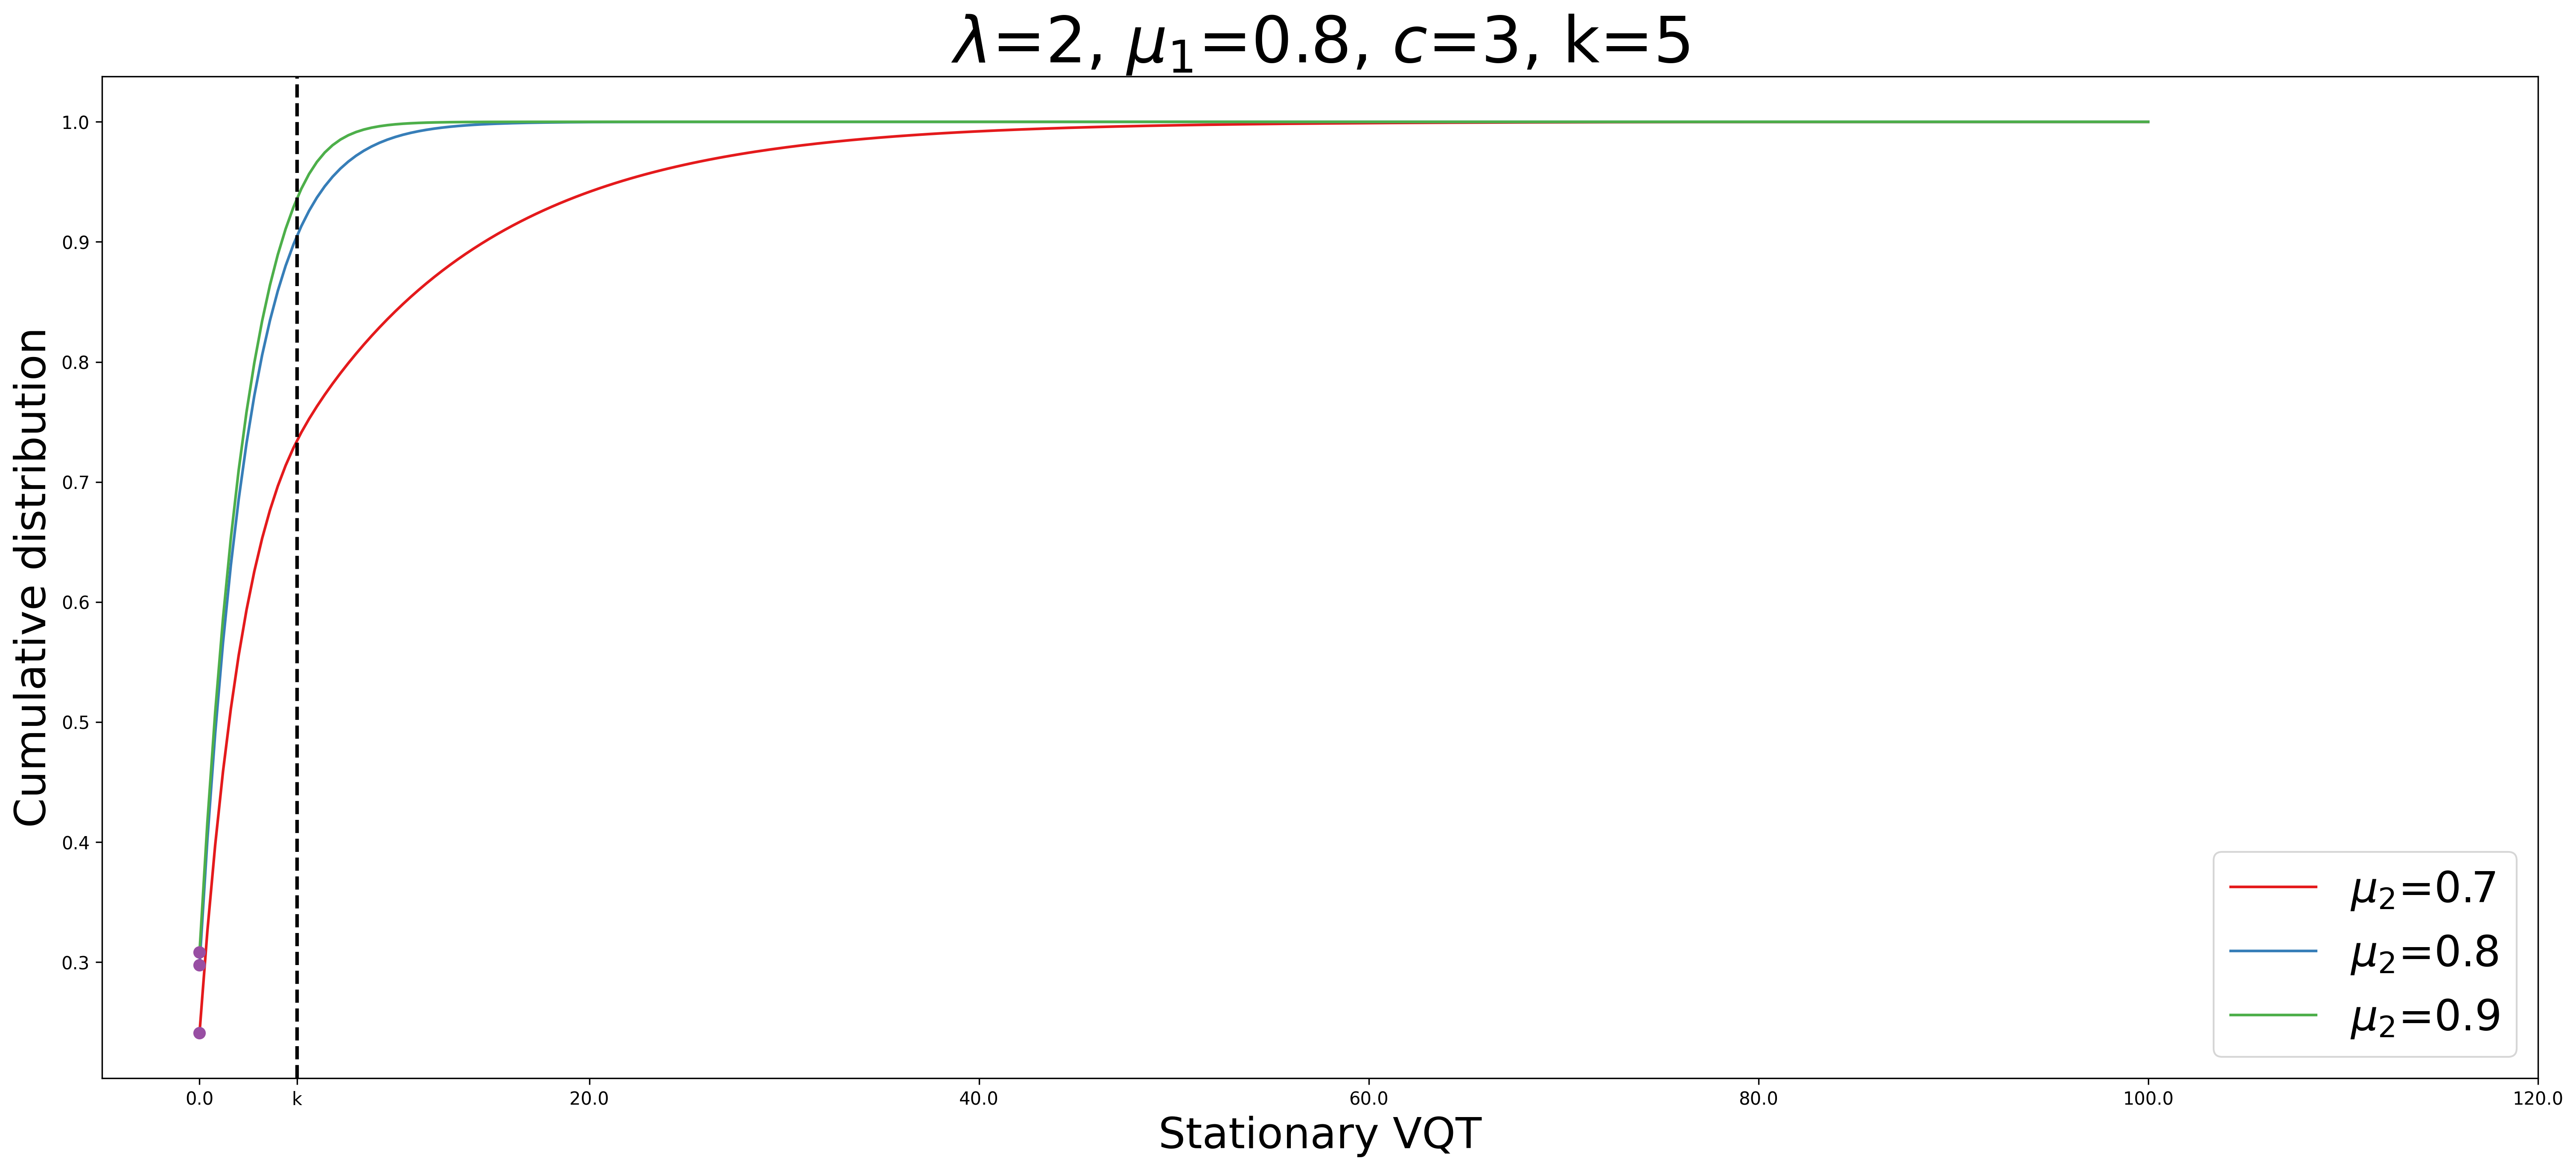

In [8]:
# A. -- from Ren√© Bekker email on 22/03/2021
## Impact of \mu_2 on cumulative waiting time distribution. 
## It seems interesting to see what the impact is of \mu_2 compared to \mu_1 (cases larger, equal, and smaller). 
## The case that the rates are equal is the `standard assumption‚Äô, 
## whereas the other two situations correspond to a speedup or slowdown effect.
# Possible parameters: 
## k=5, c=3, \mu_1 =0.8, \lambda = 2 and three lines for \mu_2 (taking 0.9, 0.8, and 0.7).
def mu2_graph(Œª=2, Œº1=0.8, c=3, k=5, title=True, save=False):
    Œº2range = [0.7,0.8,0.9]
    xpoints = np.linspace(start=0, stop=20*k, num=250)
    cmap = plt.get_cmap('Set1')
    plt.figure(figsize=(20, 9), dpi=300, constrained_layout=True)
    for ix, Œº2 in enumerate(Œº2range):
        VQTfun, _, _= VQT(c, Œª, Œº1, Œº2, k)
        plt.plot(xpoints, [VQTfun(x) for x in xpoints],  label=f'$\mu_2$={Œº2}', color=cmap(ix)) # plot VQT
        plt.plot(0, VQTfun(0), "o", color=cmap(c)) # mark null VQT probability
    plt.ylabel('Cumulative distribution',fontsize=24)
    plt.xlabel('Stationary VQT',fontsize=24)
    plt.gca().axvline(x=k, linewidth=2, color='k', linestyle="--") # add vertical line at k
    plt.xticks(list(plt.xticks()[0][1:]) + [k], list(plt.xticks()[0][1:]) + ["k"]) # add xtick at k
    plt.legend(loc=4, fontsize=24)
    if title: plt.title(f'$\lambda$={Œª}, $\mu_1$={Œº1}, $c$={c}, k={k}', fontsize=36)
    if save: # save picture to file
        # basedir = os.path.expanduser("~") + '/Desktop/' # put pictures in Desktop folder
        basedir = os.path.join(os.getcwd(),"img")
        filename = f'vqt_cdf_M_l{Œª}_m{Œº1}_c{c}_k{k}'
        plt.savefig(os.path.join(basedir, filename + ".pdf"), dpi=300)
        plt.savefig(os.path.join(basedir, filename +".jpeg"), dpi=300, format='JPG')
    plt.show()
mu2_graph(save=False)

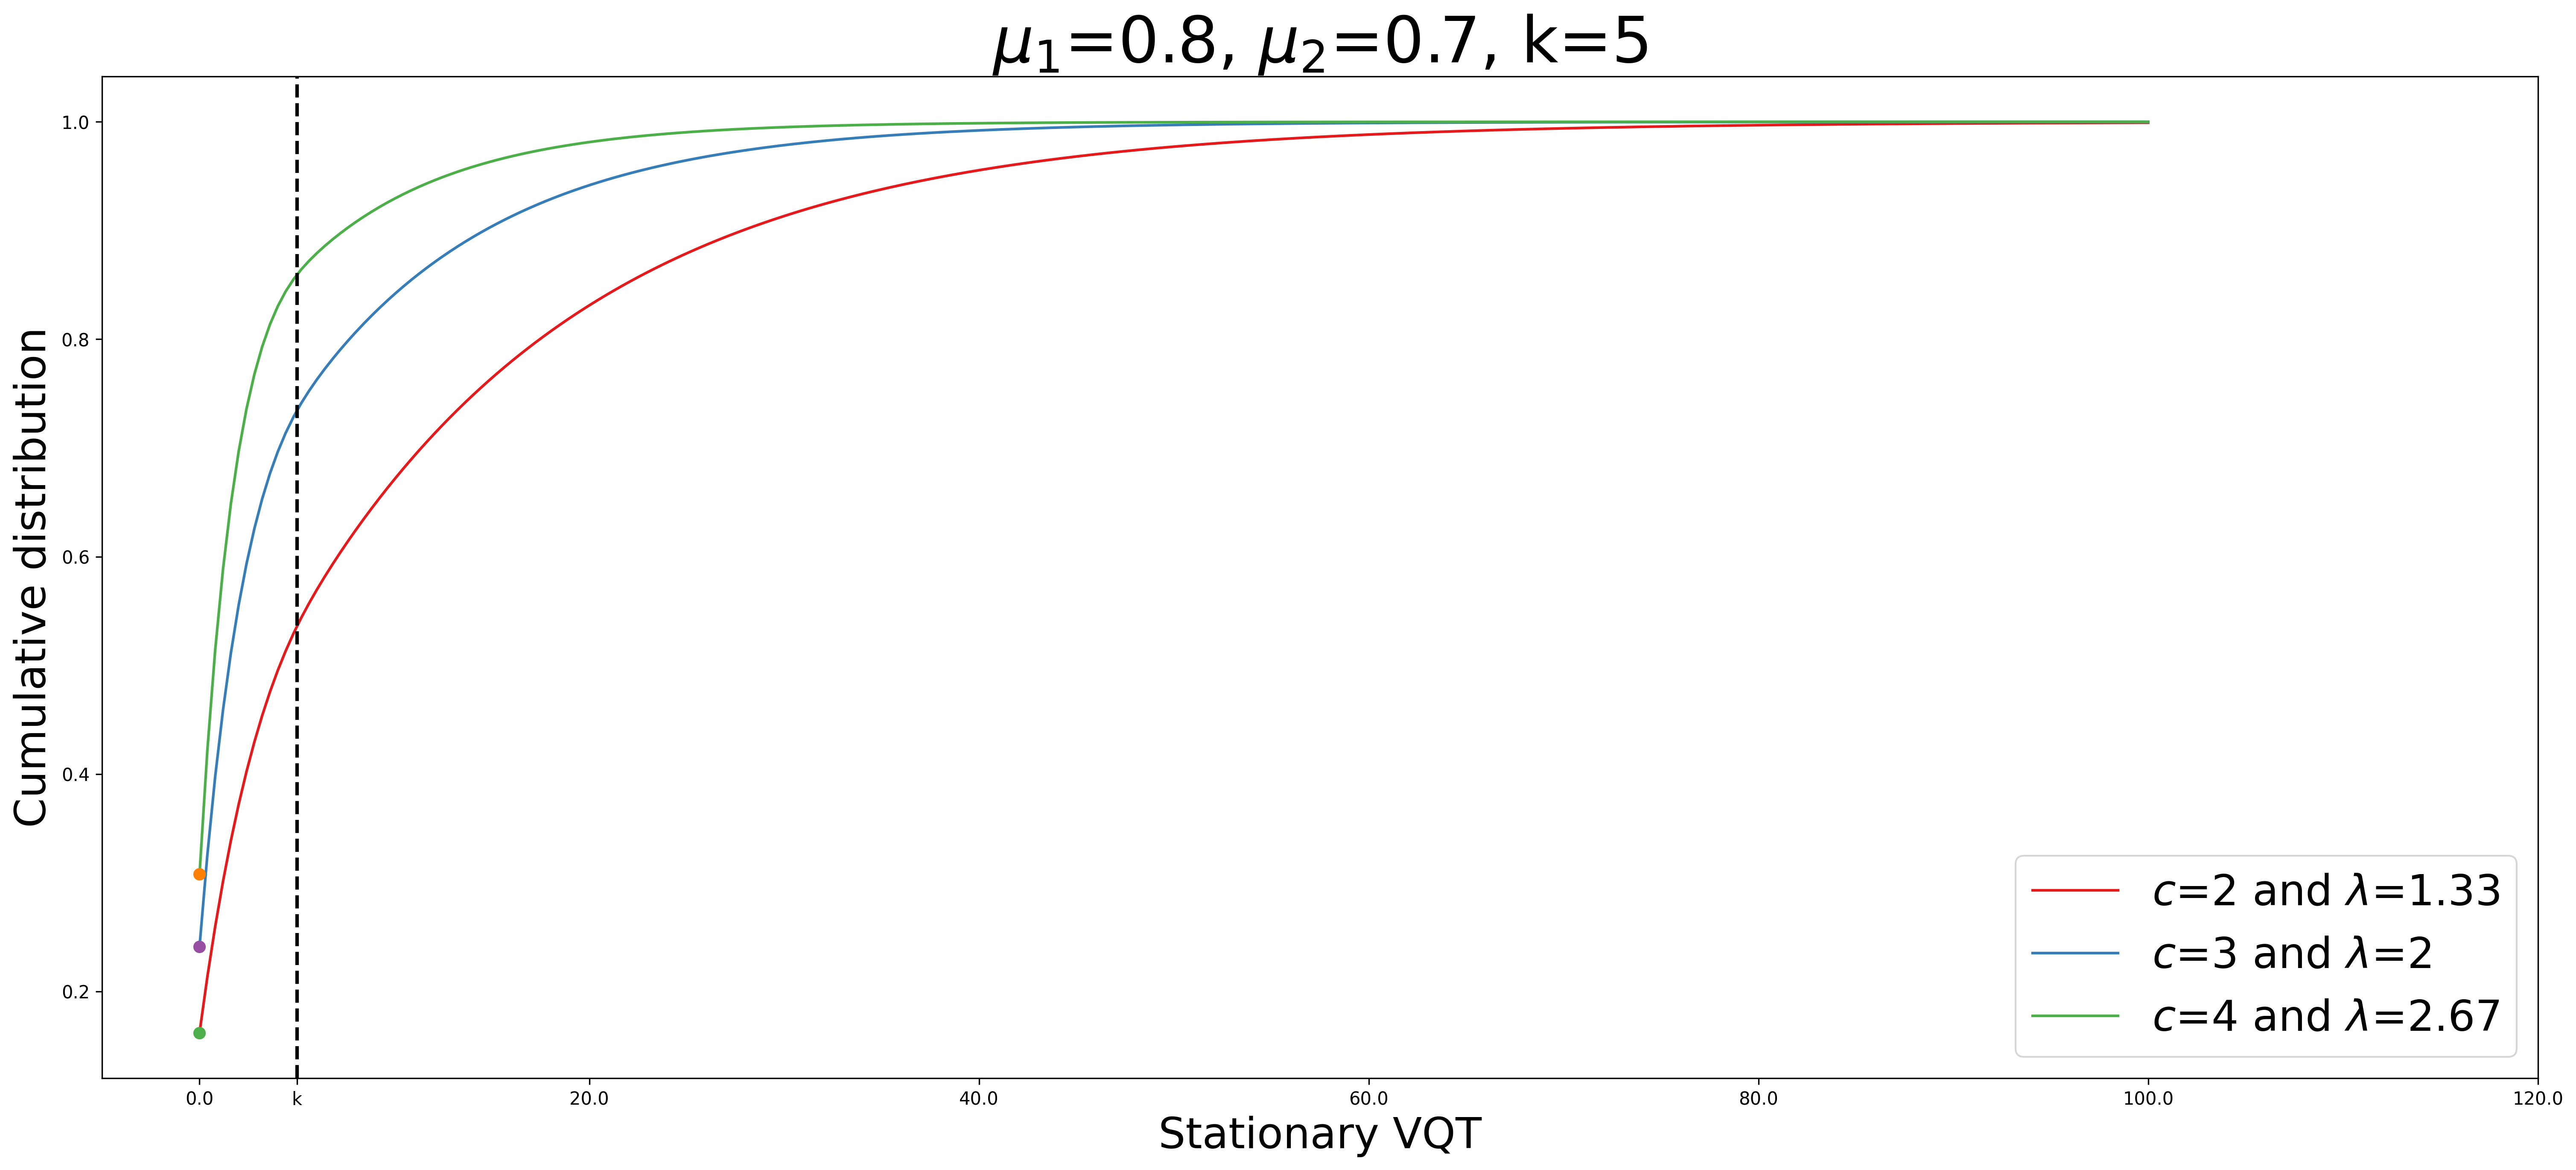

In [9]:
# B. -- from Ren√© Bekker email on 22/03/2021
## Impact of number of servers on cumulative waiting time distribution. 
## That is, what is the impact of the number of servers on system behaviour, 
## i.e. the cumulative waiting time distribution? 
## Our motivation stems from the slowdown effect, so we should focus on \mu_2 < \mu_1.
# Possible parameters: k=5, \mu_1 = 0.8, \mu_2 = 0.7, 
# and c = 2, 3, 4 with corresponding \lambda = 4/3, 2, 8/3 (such that the loads remain identical).
def cŒª_graph(Œº1=0.8, Œº2=0.7, k=5, title=True, save=False):
    cŒªrange = [(2,4/3),(3,2),(4,8/3)]
    xpoints = np.linspace(start=0, stop=20*k, num=250)
    cmap = plt.get_cmap('Set1')
    plt.figure(figsize=(20, 9), dpi=300, constrained_layout=True)
    for ix, (c,Œª) in enumerate(cŒªrange):
        VQTfun, _, _= VQT(c, Œª, Œº1, Œº2, k)
        plt.plot(xpoints, [VQTfun(x) for x in xpoints],  label=f'$c$={c} and $\lambda$={round(Œª,2)}', color=cmap(ix)) # plot VQT
        plt.plot(0, VQTfun(0), "o", color=cmap(c)) # mark null VQT probability
    plt.ylabel('Cumulative distribution',fontsize=24)
    plt.xlabel('Stationary VQT',fontsize=24)
    plt.gca().axvline(x=k, linewidth=2, color='k', linestyle="--") # add vertical line at k
    plt.xticks(list(plt.xticks()[0][1:]) + [k], list(plt.xticks()[0][1:]) + ["k"]) # add xtick at k
    plt.legend(loc=4, fontsize=24)
    if title: plt.title(f'$\mu_1$={Œº1}, $\mu_2$={Œº2}, k={k}', fontsize=36)
    if save: # save picture to file
        # basedir = os.path.expanduser("~") + '/Desktop/' # put pictures in Desktop folder
        basedir = os.path.join(os.getcwd(),"img")
        filename = f'vqt_cdf_lc_m{Œº1}_M{Œº2}_k{k}'
        plt.savefig(os.path.join(basedir, filename + ".pdf"), dpi=300)
        plt.savefig(os.path.join(basedir, filename +".jpeg"), dpi=300, format='JPG')
    plt.show()
cŒª_graph(save=False)

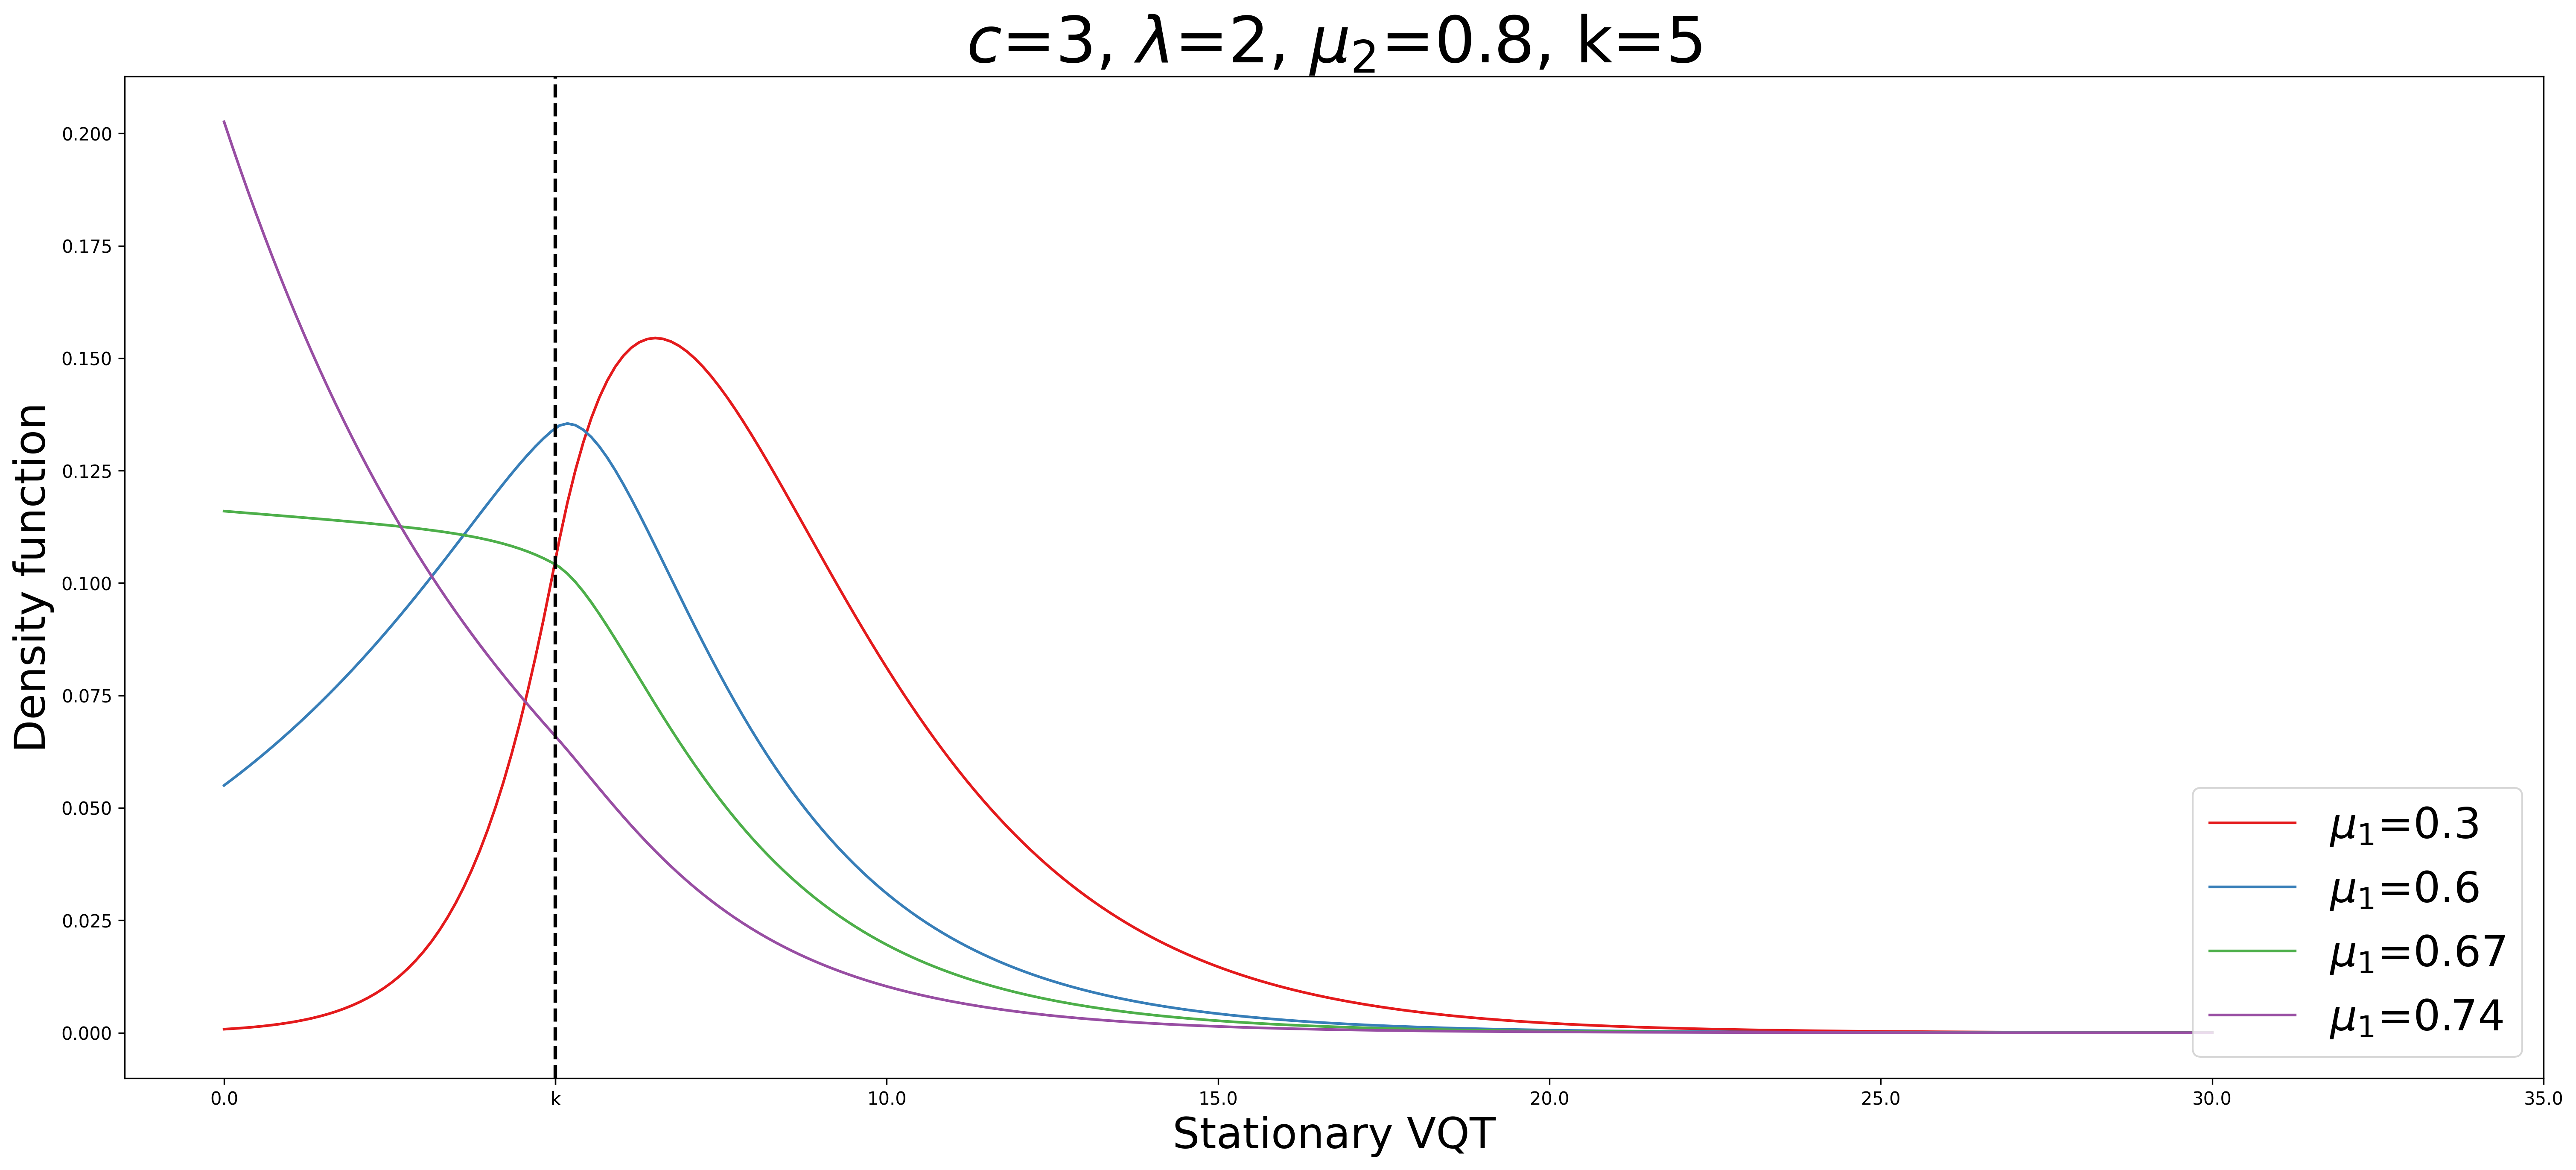

In [10]:
# C. -- from Ren√© Bekker email on 22/03/2021
## Showing the bimodal waiting time density. 
## This case corresponds to Selen et al, and should illustrate that the waiting time density (derivative of cdf) 
## has two peaks (corresponding to situation below and above k).
# Possible parameters: k=5, c=3, \lambda = 2, \mu_2 = 0.8 and \mu_1 = 0.3, 0.6, 0.67, 0.74.
def df_graph(c=3, Œª=2, Œº2=0.8, k=5, title=True, save=False):
    Œº1range = [0.3, 0.6, 0.67, 0.74]
    xpoints = np.linspace(start=0, stop=6*k, num=250)
    cmap = plt.get_cmap('Set1')
    plt.figure(figsize=(20, 9), dpi=300, constrained_layout=True)
    for ix, Œº1 in enumerate(Œº1range):
        _, VQTfun, _= VQT(c, Œª, Œº1, Œº2, k)
        plt.plot(xpoints, [VQTfun(x) for x in xpoints],  label=f'$\mu_1$={Œº1}', color=cmap(ix)) # plot VQT density
    plt.ylabel('Density function',fontsize=24)
    plt.xlabel('Stationary VQT',fontsize=24)
    plt.legend(loc=4, fontsize=24)
    plt.gca().axvline(x=k, linewidth=2, color='k', linestyle="--") # add vertical line at k
    plt.xticks(list(plt.xticks()[0][1:]) + [k], list(plt.xticks()[0][1:]) + ["k"]) # add xtick at k
    if title: plt.title(f'$c$={c}, $\lambda$={Œª}, $\mu_2$={Œº2}, k={k}', fontsize=36)
    if save: # save picture to file
        # basedir = os.path.expanduser("~") + '/Desktop/' # put pictures in Desktop folder
        basedir = os.path.join(os.getcwd(),"img")
        filename = f'vqt_df_m_l{Œª}_c{c}_M{Œº2}_k{k}'
        plt.savefig(os.path.join(basedir, filename + ".pdf"), dpi=300)
        plt.savefig(os.path.join(basedir, filename +".jpeg"), dpi=300, format='JPG')
    plt.show()
df_graph(save=False)

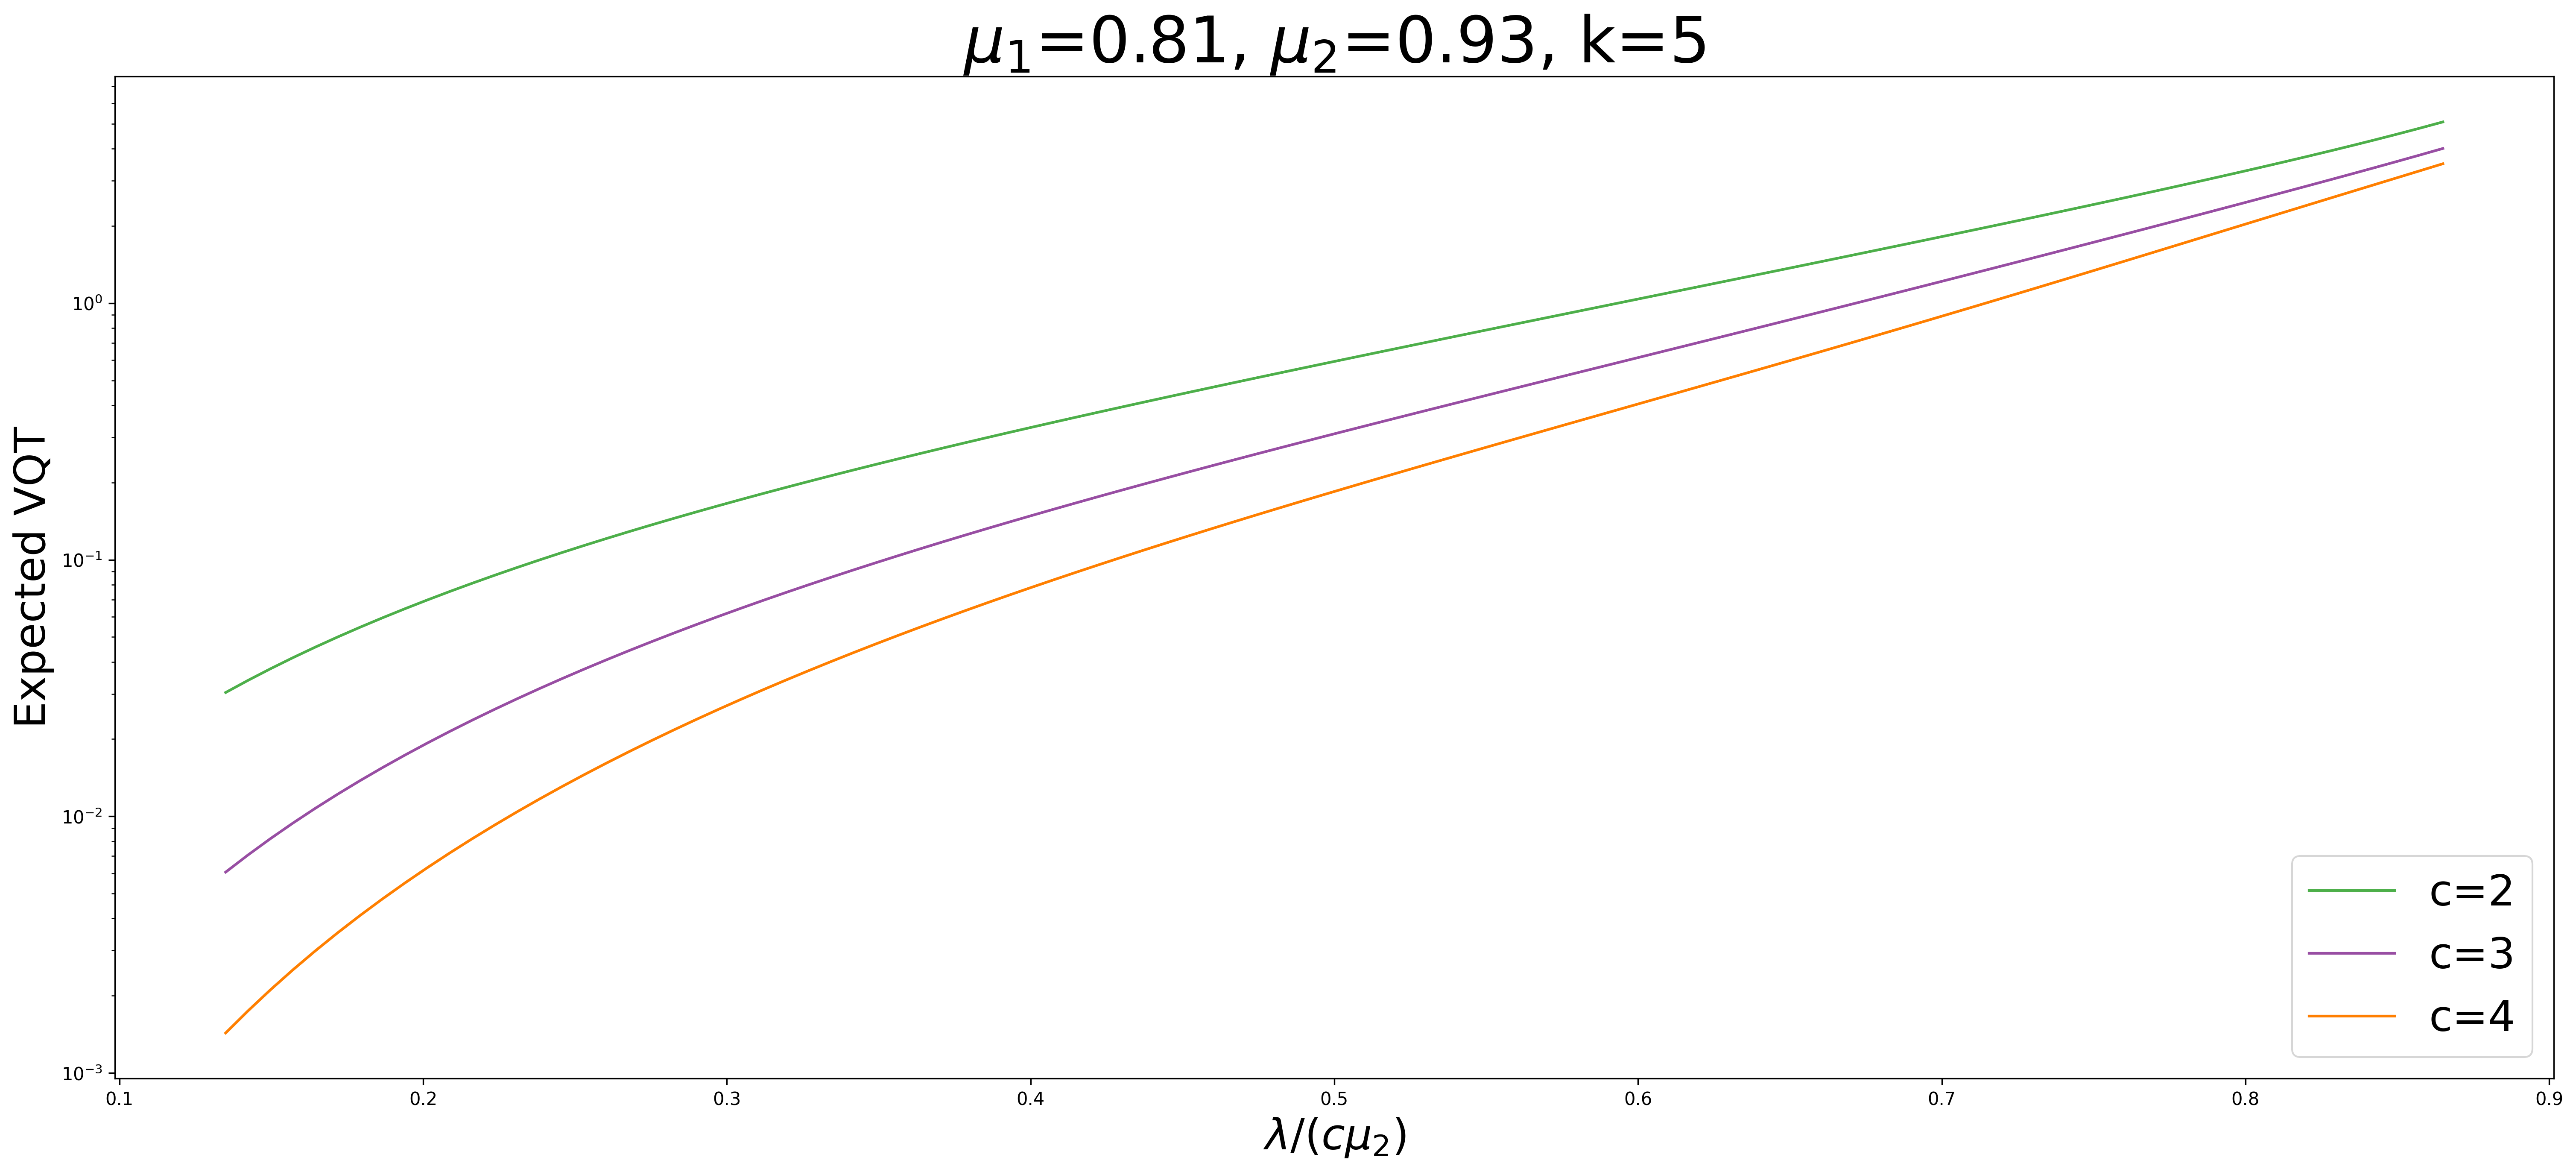

In [11]:
# D. -- from Ren√© Bekker email on 22/03/2021
# Impact of load on expected waiting time. 
# This may be a little more involved, as we do not yet compute expected values (only cdf‚Äôs). 
# So, I am not sure yet how this works out. 
# The idea is to show a similar behaviour of the expected waiting time as for regulare queues as the load increases. Now, there will be an asymptote as the system tends to become unstable, but I suspect that the behaviour might be different. On the horizontal axis, we should vary \lambda; on the vertical axis we should see the expected waiting time.
# Possible parameters: k=5, c=3, \mu_1 = 0.81, \mu_2 = 0.93 and c= 2,3,4.
def mean_graph(Œº1=0.81, Œº2=0.93, k=5, title=True, save=False):
    crange = range(2,5)
    xpoints = np.linspace(start=0.135, stop=0.865, num=100)
    cmap = plt.get_cmap('Set1')
    plt.figure(figsize=(20, 9), dpi=300, constrained_layout=True)
    plt.yscale('log')
    for c in crange:
        meanPoints = [VQT(c, x*c*Œº2, Œº1, Œº2, k)[2] for x in xpoints]
        plt.plot(xpoints, meanPoints,  label=f'c={c}', color=cmap(c)) # plot mean VQT
    plt.ylabel('Expected VQT',fontsize=24)
    plt.xlabel('$\lambda/(c\mu_2)$',fontsize=24)
    plt.legend(loc=4, fontsize=24)
    if title: plt.title(f'$\mu_1$={Œº1}, $\mu_2$={Œº2}, k={k}', fontsize=36)
    if save: # save picture to file
        # basedir = os.path.expanduser("~") + '/Desktop/' # put pictures in Desktop folder
        basedir = os.path.join(os.getcwd(),"img")
        filename = f'vqt_mean_lc_m{Œº1}_M{Œº2}_k{k}'
        plt.savefig(os.path.join(basedir, filename + ".pdf"), dpi=300)
        plt.savefig(os.path.join(basedir, filename +".jpeg"), dpi=300, format='JPG')
    plt.show()
mean_graph(save=False)

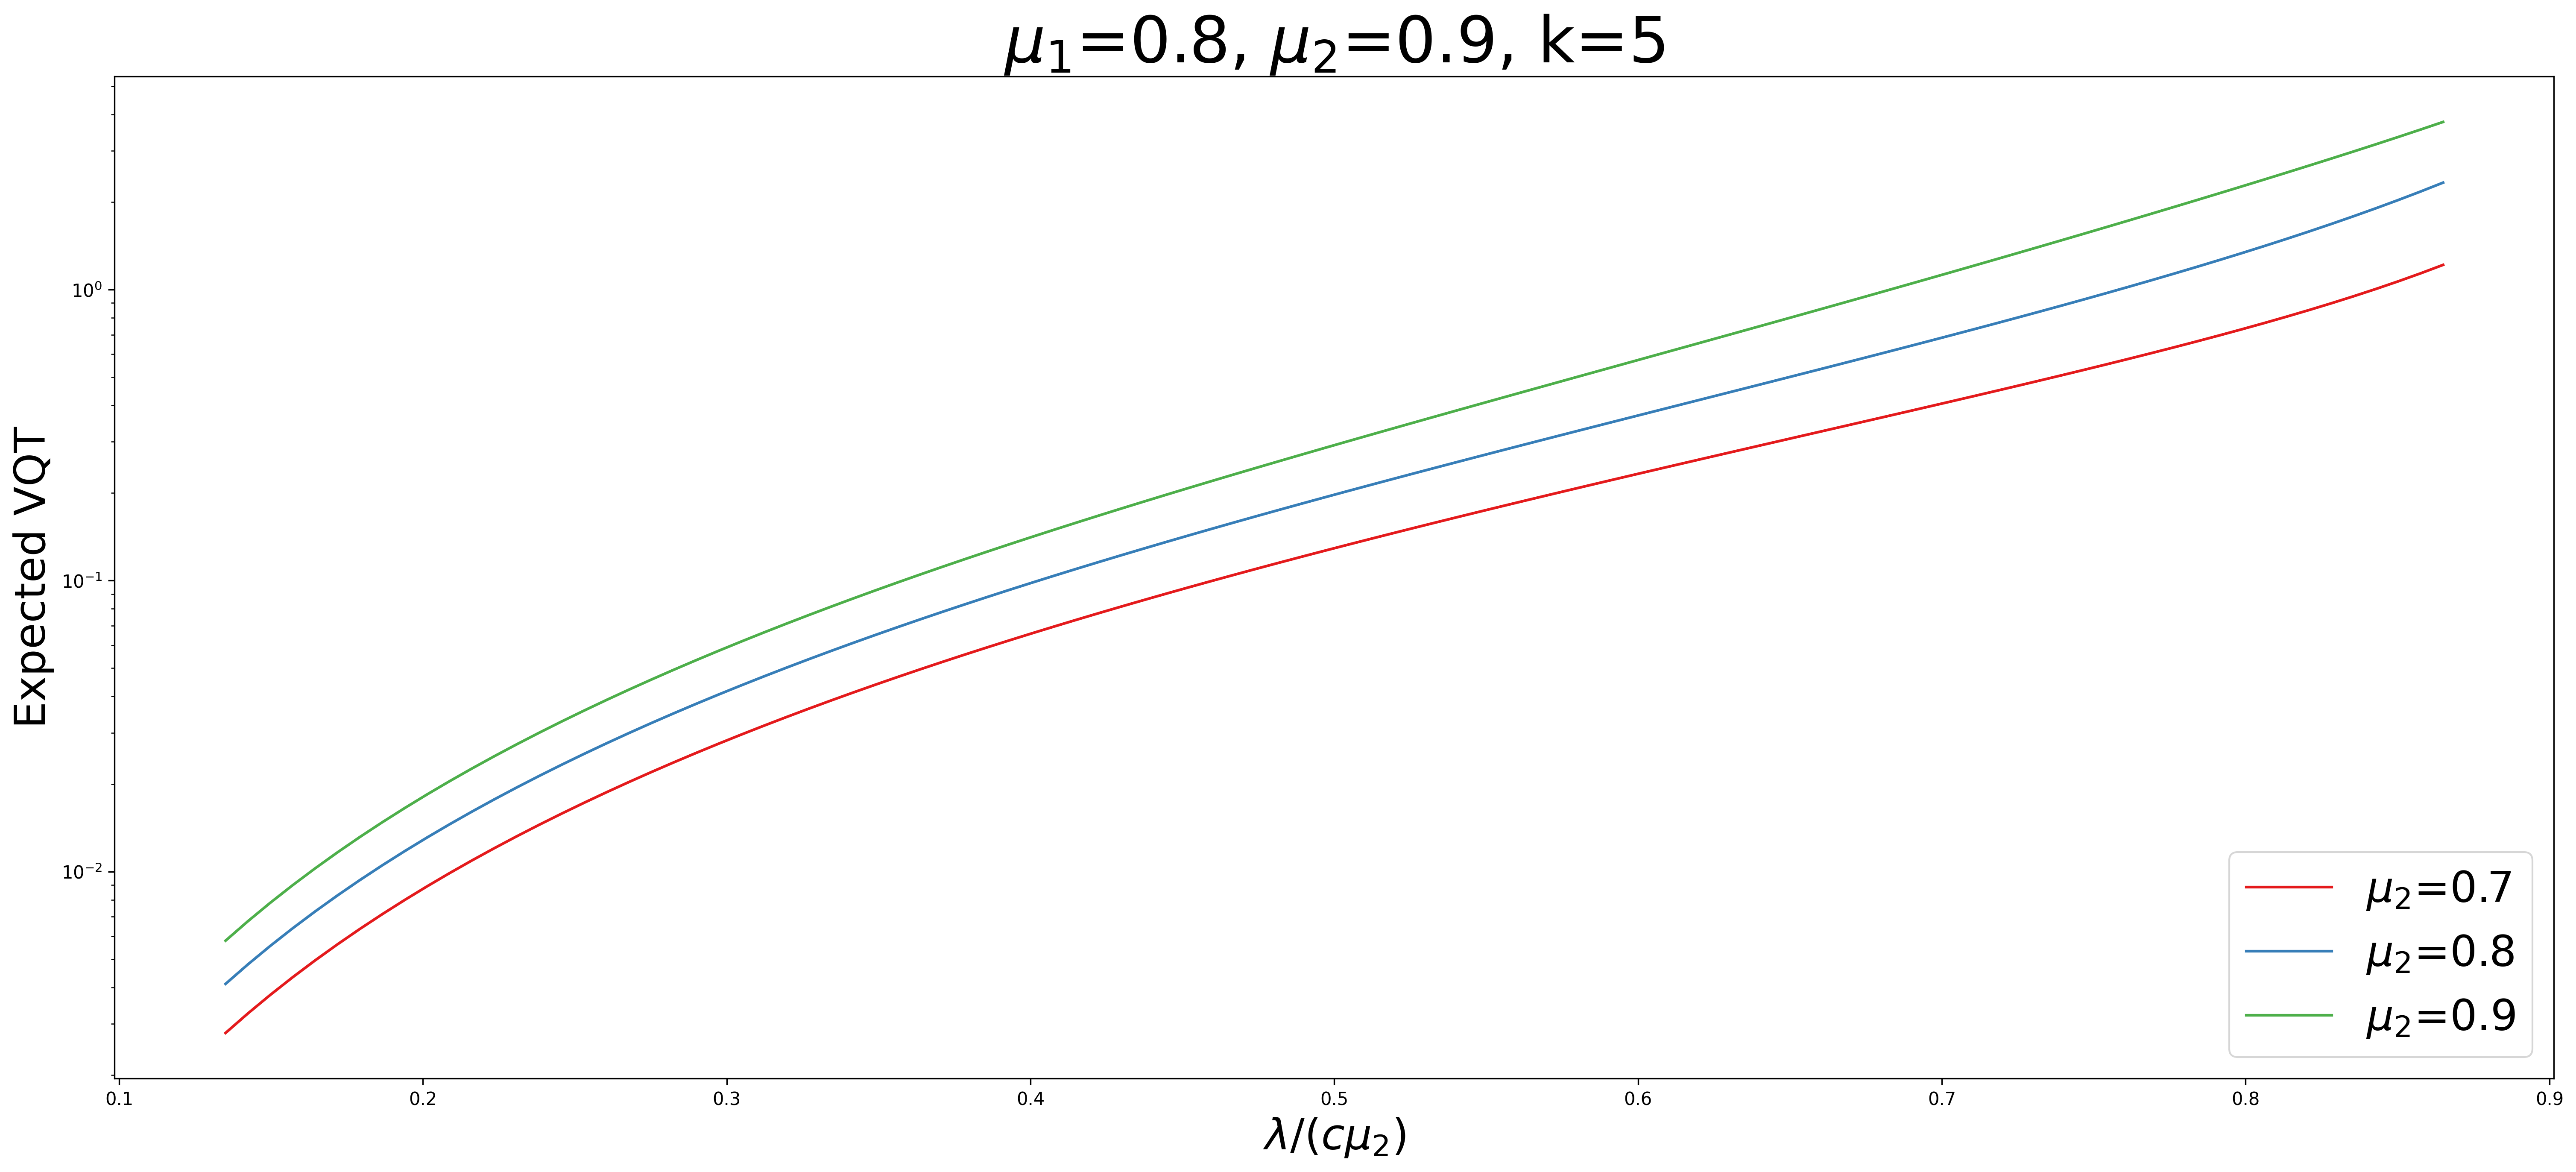

In [13]:
def add_mean_graph(c=3, Œº1=0.8, k=5, title=True, save=False):
    Œº2range = [0.7,0.8,0.9]
    xpoints = np.linspace(start=0.135, stop=0.865, num=100)
    cmap = plt.get_cmap('Set1')
    plt.figure(figsize=(20, 9), dpi=300, constrained_layout=True)
    plt.yscale('log')
    for ix, Œº2 in enumerate(Œº2range):
        meanPoints = [VQT(c, x*c*Œº2, Œº1, Œº2, k)[2] for x in xpoints]
        plt.plot(xpoints, meanPoints,  label=f'$\mu_2$={Œº2}', color=cmap(ix)) # plot mean VQT
    plt.ylabel('Expected VQT',fontsize=24)
    plt.xlabel('$\lambda/(c\mu_2)$',fontsize=24)
    plt.legend(loc=4, fontsize=24)
    if title: plt.title(f'$\mu_1$={Œº1}, $\mu_2$={Œº2}, k={k}', fontsize=36)
    if save: # save picture to file
        # basedir = os.path.expanduser("~") + '/Desktop/' # put pictures in Desktop folder
        basedir = os.path.join(os.getcwd(),"img")
        filename = f'vqt_mean_lM_c{c}_m{Œº1}_k{k}'
        plt.savefig(os.path.join(basedir, filename + ".pdf"), dpi=300)
        plt.savefig(os.path.join(basedir, filename +".jpeg"), dpi=300, format='JPG')
    plt.show()
add_mean_graph(save=False)